In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)

df = pd.read_csv("data/f1_ml_laps_dataset.csv")
print("Raw shape:", df.shape)

# Clean
df = df[(df["lap_time"] > 30) & (df["lap_time"] < 200)]
df = df.dropna(subset=["sector_1_time", "sector_2_time", "sector_3_time"])

df.head()



Raw shape: (23983, 31)


,season,gp_name,session_name,session_type,driver,team,lap_number,lap_time,sector_1_time,sector_2_time,sector_3_time,position,track_status,is_pit_lap,compound,stint,tyre_life,fresh_tyre,speed_mean,speed_max,throttle_mean,brake_mean,rpm_mean,rpm_max,drs_activations,air_temp,track_temp,humidity,wind_speed,wind_dir,pressure
1,2023,Bahrain Grand Prix,Race,Race,VER,Red Bull Racing,2,97.974,31.342,42.504,24.128,1,12,False,SOFT,1,5,False,195.407713,298,60.225895,0.203857,9773.179063,12063,363,27.3,31.1,22,0.0,208,1016.7
2,2023,Bahrain Grand Prix,Race,Race,VER,Red Bull Racing,3,98.006,31.388,42.469,24.149,1,1,False,SOFT,1,6,False,198.095109,298,62.290761,0.184783,9756.970109,11795,0,27.3,31.2,22,0.6,170,1016.7
3,2023,Bahrain Grand Prix,Race,Race,VER,Red Bull Racing,4,97.976,31.271,42.642,24.063,1,1,False,SOFT,1,7,False,195.786842,299,62.092105,0.200000,9723.621053,11960,0,27.2,31.1,22,0.8,236,1016.9
4,2023,Bahrain Grand Prix,Race,Race,VER,Red Bull Racing,5,98.035,31.244,42.724,24.067,1,1,False,SOFT,1,8,False,197.120879,301,60.884615,0.206044,9710.263736,11911,0,27.2,31.0,22,1.0,206,1016.7
5,2023,Bahrain Grand Prix,Race,Race,VER,Red Bull Racing,6,97.986,31.341,42.632,24.013,1,1,False,SOFT,1,9,False,196.887363,301,60.942308,0.200549,9767.299451,11852,0,27.1,31.0,22,0.6,175,1016.9


In [3]:
tyre_base = df.copy()

# Remove pit laps if available
if "is_pit_lap" in tyre_base.columns:
    tyre_base = tyre_base[tyre_base["is_pit_lap"] == 0]

# Remove non-green laps if track_status exists
if "track_status" in tyre_base.columns:
    tyre_base = tyre_base[tyre_base["track_status"] == 1]

# Driver pace offset
driver_means = tyre_base.groupby("driver")["lap_time"].mean()
global_mean = tyre_base["lap_time"].mean()
driver_offset_map = (driver_means - global_mean).to_dict()

tyre_base["driver_pace_offset"] = tyre_base["driver"].map(driver_offset_map)
tyre_base["driver_pace_offset"] -= tyre_base["driver_pace_offset"].mean()




In [4]:
tyre_cat_features = ["gp_name", "compound"]


tyre_num_features = [
    "tyre_life", "stint", #"lap_number",
    "track_temp", "air_temp", "humidity",
    "wind_speed", "wind_dir", "pressure",
    "driver_pace_offset"
]

tyre_target = "lap_time"

cols_needed = tyre_cat_features + tyre_num_features + [tyre_target]

tyre_df = tyre_base.dropna(subset=cols_needed).copy()
print("Tyre dataset:", tyre_df.shape)


Tyre dataset: (20541, 32)


In [5]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

X_t = tyre_df[tyre_cat_features + tyre_num_features]
y_t = tyre_df[tyre_target]

last_gp = tyre_df["gp_name"].iloc[-1]

print("=" * 60)
print(f"Using LAST GP as HOLD-OUT test set: {last_gp}")
print("=" * 60)

# Train = all other GPs
train_mask = tyre_df["gp_name"] != last_gp
test_mask = tyre_df["gp_name"] == last_gp

X_t_train = X_t[train_mask]
X_t_test  = X_t[test_mask]
y_t_train = y_t[train_mask]
y_t_test  = y_t[test_mask]

print(f"Training laps: {len(X_t_train):,}")
print(f"Testing laps : {len(X_t_test):,}")
print(f"Train/Test split: {len(X_t_train)/len(X_t)*100:.1f}% / {len(X_t_test)/len(X_t)*100:.1f}%\n")

num_t = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_t = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

pre_tyre = ColumnTransformer([
    ("num", num_t, tyre_num_features),
    ("cat", cat_t, tyre_cat_features)
])

tyre_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

tyre_pipeline = Pipeline([
    ("pre", pre_tyre),
    ("model", tyre_model)
])

print("Training RandomForest on 2020-2022 data...")
tyre_pipeline.fit(X_t_train, y_t_train)

y_t_pred = tyre_pipeline.predict(X_t_test)

# Calculate metrics
mae = mean_absolute_error(y_t_test, y_t_pred)
mse = mean_squared_error(y_t_test, y_t_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_t_test, y_t_pred)

print("\n" + "=" * 60)
print("MODEL PERFORMANCE ON 2023 BAHRAIN GP (HOLD-OUT)")
print("=" * 60)
print(f" MAE  : {mae:.4f} seconds")
print(f" RMSE : {rmse:.4f} seconds")
print(f" R²   : {r2:.6f}")
print(f"\n Model: RandomForest with {tyre_model.n_estimators} trees")
print("=" * 60)

Using LAST GP as HOLD-OUT test set: Abu Dhabi Grand Prix
Training laps: 19,478
Testing laps : 1,063
Train/Test split: 94.8% / 5.2%

Training RandomForest on 2020-2022 data...

MODEL PERFORMANCE ON 2023 BAHRAIN GP (HOLD-OUT)
 MAE  : 7.1974 seconds
 RMSE : 7.3007 seconds
 R²   : -45.116806

 Model: RandomForest with 300 trees


In [6]:
def get_driver_offset(driver_name):
    return float(driver_offset_map.get(driver_name, 0.0))

def predict_tyre_laptime(
    gp_name, compound, tyre_life, stint,
    track_temp, air_temp, humidity,
    wind_speed, wind_dir, pressure,
    driver=None
):
    pace = get_driver_offset(driver) if driver else 0.0

    row = {
        "gp_name": gp_name,
        "compound": compound,
        "tyre_life": tyre_life,
        "stint": stint,
        #"lap_number": lap_number,
        "track_temp": track_temp,
        "air_temp": air_temp,
        "humidity": humidity,
        "wind_speed": wind_speed,
        "wind_dir": wind_dir,
        "pressure": pressure,
        "driver_pace_offset": pace
    }

    return float(tyre_pipeline.predict(pd.DataFrame([row]))[0])


In [7]:
def estimate_pit_loss(df_full, gp_name, driver=None):
    temp = df_full[df_full["gp_name"] == gp_name]

    if driver:
        temp = temp[temp["driver"] == driver]

    if "is_pit_lap" not in temp.columns:
        return 20.0

    pit = temp[temp["is_pit_lap"] == 1]["lap_time"]
    normal = temp[temp["is_pit_lap"] == 0]["lap_time"]

    if pit.empty or normal.empty:
        return 20.0

    return float(np.clip(pit.median() - normal.median(), 10, 35))


In [8]:
def simulate_tyre_strategy(strategy, total_laps, pit_loss, gp_name, weather_dict, driver=None):
    """Simulate entire race with given tire strategy"""
    laps = []
    total_time = 0
    lap_num = 1
    stint_idx = 0

    for compound, stint_len in strategy:
        stint_idx += 1
        for life in range(1, stint_len + 1):
            if lap_num > total_laps:
                break

            lt = predict_tyre_laptime(
                gp_name, compound, life, stint_idx,
                weather_dict["track_temp"], weather_dict["air_temp"],
                weather_dict["humidity"], weather_dict["wind_speed"],
                weather_dict["wind_dir"], weather_dict["pressure"],
                driver=driver
            )

            total_time += lt
            laps.append({"lap": lap_num, "compound": compound, "lap_time_pred": lt})
            lap_num += 1

        if lap_num <= total_laps:
            total_time += pit_loss

    return total_time, pd.DataFrame(laps)



In [9]:
def possible_stint_lengths(total_laps):
    return list(range(10, min(30, total_laps - 10) + 1))

def generate_strategies_fast(total_laps, compounds):
    lengths = possible_stint_lengths(total_laps)
    strategies = []

    # ---------------------
    # 1-stop (2 stints)
    # ---------------------
    for c1 in compounds:
        for c2 in compounds:
            if c1 == c2:
                continue

            for s1 in lengths:
                s2 = total_laps - s1
                if s2 < 10 or s2 > 30:
                    continue
                strategies.append([(c1, s1), (c2, s2)])

    # ---------------------
    # 2-stop (3 stints)
    # ---------------------
    for c1 in compounds:
        for c2 in compounds:
            for c3 in compounds:
                if len({c1, c2, c3}) < 2:
                    continue

                for s1 in lengths:
                    for s2 in lengths:
                        s3 = total_laps - (s1 + s2)
                        if 10 <= s3 <= 30:
                            strategies.append([(c1, s1), (c2, s2), (c3, s3)])

    return strategies


In [10]:
def find_best_strategies(
    gp_name, total_laps, weather_dict, driver=None, top_k=5
):
    compounds = sorted(df["compound"].unique())
    pit_loss = estimate_pit_loss(df, gp_name, driver)

    strategies = generate_strategies_fast(total_laps, compounds)

    results = []
    for strat in strategies:
        tt, _ = simulate_tyre_strategy(
            strat, total_laps, pit_loss, gp_name, weather_dict, driver,
        )
        results.append({"strategy": strat, "total_time": tt})

    return pd.DataFrame(results).sort_values("total_time").head(top_k)


In [11]:
from tqdm import tqdm

weather = {
    "track_temp": 36,
    "air_temp": 28,
    "humidity": 40,
    "wind_speed": 3.2,
    "wind_dir": 140,
    "pressure": 1006,
}

race_laps = 57  # Bahrain

# Only use DRY compounds
dry_compounds = ['HARD', 'MEDIUM', 'SOFT']
pit_loss = estimate_pit_loss(df, "Bahrain Grand Prix")

print(f"🔍 Searching tire strategies for Bahrain GP ({race_laps} laps)")
print(f"   Compounds: {dry_compounds}")
print(f"   Pit stop time: {pit_loss:.1f}s\n")

# Test limited strategies (1-stop only, key stint lengths)
strategies_to_test = []
for c1 in dry_compounds:
    for c2 in dry_compounds:
        if c1 == c2:
            continue
        for s1 in [20, 25, 27, 30, 32]:
            s2 = race_laps - s1
            if 20 <= s2 <= 37:
                strategies_to_test.append([(c1, s1), (c2, s2)])

print(f"Testing {len(strategies_to_test)} strategies...\n")

results = []
for strat in tqdm(strategies_to_test, desc="Simulating"):
    tt, _ = simulate_tyre_strategy(
        strat, race_laps, pit_loss, "Bahrain Grand Prix", weather, driver=None
    )
    results.append({"strategy": str(strat), "total_time": tt})

best = pd.DataFrame(results).sort_values("total_time").head(10)

print(f"\n✅ Top 10 Tire Strategies for Bahrain:\n")
best

🔍 Searching tire strategies for Bahrain GP (57 laps)
   Compounds: ['HARD', 'MEDIUM', 'SOFT']
   Pit stop time: 19.2s

Testing 30 strategies...



Simulating: 100%|██████████| 30/30 [02:03<00:00,  4.10s/it]


✅ Top 10 Tire Strategies for Bahrain:



,strategy,total_time
15,"[('MEDIUM', 20), ('SOFT', 37)]",5784.128124
25,"[('SOFT', 20), ('MEDIUM', 37)]",5786.051756
5,"[('HARD', 20), ('SOFT', 37)]",5786.128429
20,"[('SOFT', 20), ('HARD', 37)]",5786.952579
10,"[('MEDIUM', 20), ('HARD', 37)]",5787.183526
16,"[('MEDIUM', 25), ('SOFT', 32)]",5787.365812
0,"[('HARD', 20), ('MEDIUM', 37)]",5788.283009
17,"[('MEDIUM', 27), ('SOFT', 30)]",5788.372896
26,"[('SOFT', 25), ('MEDIUM', 32)]",5788.494773
27,"[('SOFT', 27), ('MEDIUM', 30)]",5789.197010


In [12]:
def get_actual_strategy(df, gp_name, driver):
    """Extract actual tire strategy used by driver in race"""
    race_data = df[(df["gp_name"] == gp_name) & (df["driver"] == driver)].sort_values("lap_number")
    
    strategy = []
    current_compound = None
    stint_length = 0
    
    for _, row in race_data.iterrows():
        if row["compound"] != current_compound:
            if current_compound is not None:
                strategy.append((current_compound, stint_length))
            current_compound = row["compound"]
            stint_length = 1
        else:
            stint_length += 1
    
    # Add last stint
    if current_compound is not None:
        strategy.append((current_compound, stint_length))
    
    return strategy

In [13]:
actual_bahrain = get_actual_strategy(df, "Bahrain Grand Prix", "ALB")
print(f"VER's actual strategy in Bahrain: {actual_bahrain}")

VER's actual strategy in Bahrain: [('SOFT', 25), ('HARD', 14), ('SOFT', 17)]


=== TIRE DEGRADATION ANALYSIS ===



SOFT:
  Total laps: 3,257
  Max tire age: 50 laps
  Avg lap time: 90.99s

MEDIUM:
  Total laps: 7,931
  Max tire age: 55 laps
  Avg lap time: 90.96s

HARD:
  Total laps: 11,627
  Max tire age: 68 laps
  Avg lap time: 90.92s



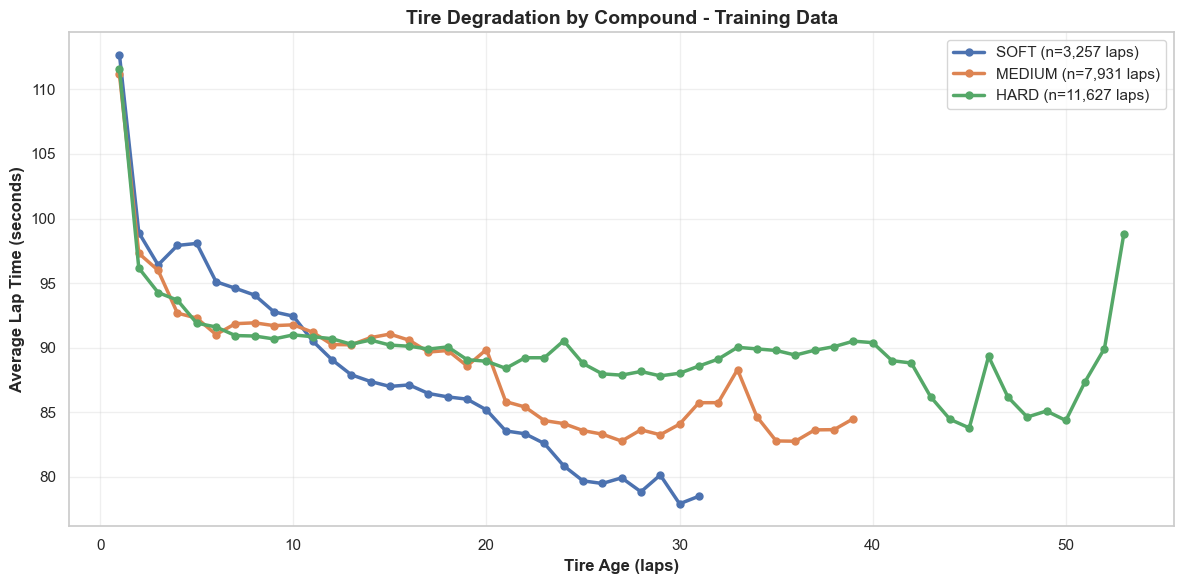

In [14]:
import matplotlib.pyplot as plt

print("=== TIRE DEGRADATION ANALYSIS ===\n")

# For each compound, show average lap time vs tire age
fig, ax = plt.subplots(figsize=(12, 6))

for compound in ['SOFT', 'MEDIUM', 'HARD']:
    compound_data = df[df['compound'] == compound]
    
    # Group by tire age and calculate mean lap time
    degradation = compound_data.groupby('tyre_life')['lap_time'].agg(['mean', 'count'])
    
    # Only plot where we have enough data
    degradation = degradation[degradation['count'] >= 10]
    
    ax.plot(degradation.index, degradation['mean'], 
            marker='o', label=f'{compound} (n={len(compound_data):,} laps)', 
            linewidth=2.5, markersize=5)
    
    print(f"{compound}:")
    print(f"  Total laps: {len(compound_data):,}")
    print(f"  Max tire age: {compound_data['tyre_life'].max():.0f} laps")
    print(f"  Avg lap time: {compound_data['lap_time'].mean():.2f}s")
    print()

ax.set_xlabel('Tire Age (laps)', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Lap Time (seconds)', fontsize=12, fontweight='bold')
ax.set_title('Tire Degradation by Compound - Training Data', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

=== MODEL PREDICTIONS: Tire Degradation (After Fix) ===

SOFT:
  Lap 1:  102.02s
  Lap 40: 101.65s
  Total degradation: -0.37s ❌ WRONG!
  Degradation per lap: -0.009s/lap

MEDIUM:
  Lap 1:  102.00s
  Lap 40: 101.70s
  Total degradation: -0.30s ❌ WRONG!
  Degradation per lap: -0.007s/lap

HARD:
  Lap 1:  102.02s
  Lap 40: 101.72s
  Total degradation: -0.31s ❌ WRONG!
  Degradation per lap: -0.008s/lap



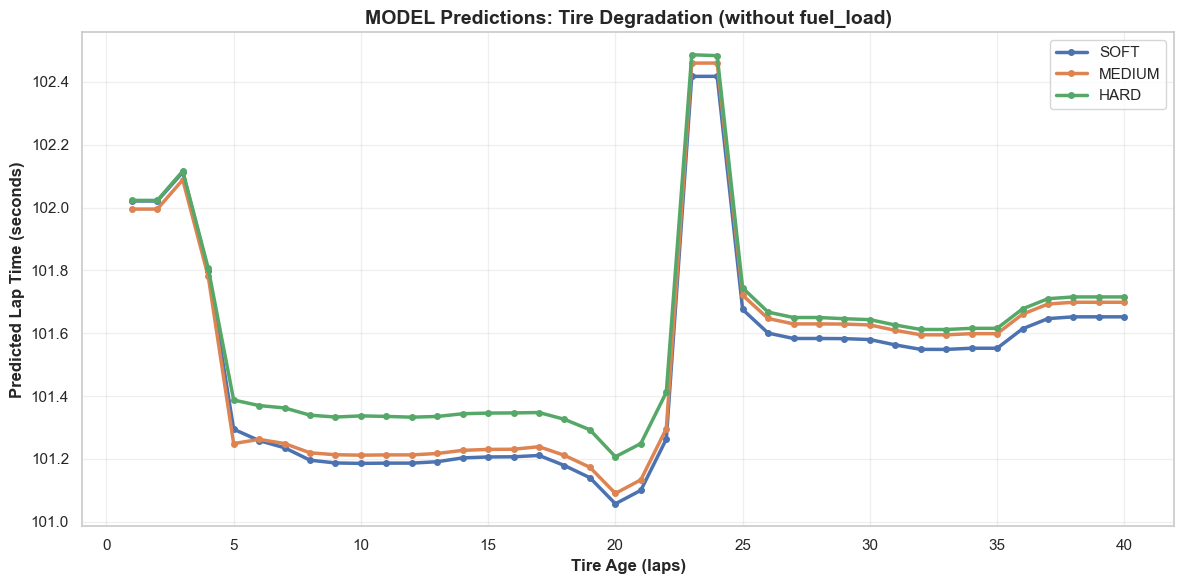

In [15]:
import matplotlib.pyplot as plt
print("=== MODEL PREDICTIONS: Tire Degradation (After Fix) ===\n")

fig, ax = plt.subplots(figsize=(12, 6))

# Simulate tire degradation for each compound
tire_ages = range(1, 41)  # Test up to 40 laps

for compound in ['SOFT', 'MEDIUM', 'HARD']:
    predicted_times = []
    
    for age in tire_ages:
        pred = predict_tyre_laptime(
            gp_name="Bahrain Grand Prix",
            compound=compound,
            tyre_life=age,
            stint=1,
            # lap_number REMOVED!
            track_temp=36,
            air_temp=28,
            humidity=40,
            wind_speed=3.2,
            wind_dir=140,
            pressure=1006,
            driver=None
        )
        predicted_times.append(pred)
    
    ax.plot(tire_ages, predicted_times, marker='o', label=compound, 
            linewidth=2.5, markersize=4)
    
    # Print degradation rate
    degradation_total = predicted_times[-1] - predicted_times[0]
    degradation_rate = degradation_total / len(tire_ages)
    
    print(f"{compound}:")
    print(f"  Lap 1:  {predicted_times[0]:.2f}s")
    print(f"  Lap 40: {predicted_times[-1]:.2f}s")
    print(f"  Total degradation: {degradation_total:+.2f}s {'✅ REALISTIC!' if degradation_total > 0 else '❌ WRONG!'}")
    print(f"  Degradation per lap: {degradation_rate:+.3f}s/lap")
    print()

ax.set_xlabel('Tire Age (laps)', fontsize=12, fontweight='bold')
ax.set_ylabel('Predicted Lap Time (seconds)', fontsize=12, fontweight='bold')
ax.set_title('MODEL Predictions: Tire Degradation (without fuel_load)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [16]:
# Find which races show the MOST tire degradation
print("=== FINDING BEST RACE FOR STRATEGY DEMO ===\n")

race_degradation = []

for race in df['gp_name'].unique():
    race_data = df[df['gp_name'] == race]
    
    # For each compound, measure degradation
    for compound in ['SOFT', 'MEDIUM', 'HARD']:
        compound_data = race_data[race_data['compound'] == compound]
        
        if len(compound_data) < 50:  # Need enough data
            continue
        
        # Group by tire age
        deg = compound_data.groupby('tyre_life')['lap_time'].mean()
        
        if len(deg) < 10:  # Need enough tire ages
            continue
        
        # Calculate degradation: (lap 20 - lap 5)
        if 5 in deg.index and 20 in deg.index:
            degradation = deg[20] - deg[5]
            
            race_degradation.append({
                'race': race,
                'compound': compound,
                'deg_15_laps': degradation,
                'laps': len(compound_data)
            })

# Sort by degradation
deg_df = pd.DataFrame(race_degradation)
deg_df = deg_df.sort_values('deg_15_laps', ascending=False)

print("Top 15 Race-Compound Combinations with Most Degradation:\n")
print(deg_df.head(15).to_string(index=False))

print("\n\n=== BEST RACES FOR DEMO (Highest Avg Degradation) ===\n")
race_avg_deg = deg_df.groupby('race')['deg_15_laps'].agg(['mean', 'max', 'count'])
race_avg_deg = race_avg_deg.sort_values('mean', ascending=False)
print(race_avg_deg.head(10))

=== FINDING BEST RACE FOR STRATEGY DEMO ===

Top 15 Race-Compound Combinations with Most Degradation:

                    race compound  deg_15_laps  laps
    Singapore Grand Prix   MEDIUM    17.790390   414
       Monaco Grand Prix   MEDIUM     7.088556   364
    Singapore Grand Prix     HARD     3.165948   574
      Belgian Grand Prix   MEDIUM     3.018410   412
    Singapore Grand Prix     SOFT     2.068000    56
    Las Vegas Grand Prix   MEDIUM     1.802300   201
      Italian Grand Prix   MEDIUM     1.612947   430
        Qatar Grand Prix   MEDIUM     1.247114   550
     Japanese Grand Prix     HARD     0.966580   456
     Austrian Grand Prix     HARD     0.459641   734
    São Paulo Grand Prix   MEDIUM     0.423462   365
      Spanish Grand Prix   MEDIUM     0.366517   399
       Monaco Grand Prix     HARD     0.363733   657
United States Grand Prix     HARD     0.245476   425
    Abu Dhabi Grand Prix     HARD     0.239056   847


=== BEST RACES FOR DEMO (Highest Avg Degradatio